<a href="https://colab.research.google.com/github/chenboju/AI/blob/main/0601_Processing_the_data_(PyTorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing the data (PyTorch)

安裝套件

In [1]:
!pip install datasets evaluate transformers[sentencepiece]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


### 先用兩筆資料來訓練一個模型

In [2]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification
#AutoModelForSequenceClassification 自動選擇適合model
# AdamW 最佳化方法

# Same as before
checkpoint = "bert-base-uncased" #載入資料集
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
sequences = [
    "I've been waiting for a HuggingFace course my whole life.",
    "This course is amazing!",
]
batch = tokenizer(sequences, padding=True, truncation=True, return_tensors="pt")   #通過模型的是batch

# 有Classification就要設定資料的labels，這邊因為兩句都是正面意義，所以設為1
batch["labels"] = torch.tensor([1, 1])

optimizer = AdamW(model.parameters()) #優化器
loss = model(**batch).loss
loss.backward()
optimizer.step()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


僅在兩個句子上訓練模型不會產生很好的結果。為了獲得更好的結果，需要準備更大的資料集。

### 載入Huggingface中的資料集
Huggingface中有數不清的資料集，比自己去網路上找還多，這邊使用MRPC資料集作為範例，該資料集由 5801 對句子組成，並帶有一個標籤，指示它們是否是相似（即，兩個句子是否表示相同的意思）。這是一個很小的資料集，容易對其進行訓練。MRPC資料集是構成GLUE 基準的10 個資料集之一，GLUE 基準是一個學術基準，用於衡量 ML 模型在 10 個不同文字分類任務中的表現。`Datasets`類別庫提供了一個非常簡單的命令來在 Hub 上下載和快取資料集
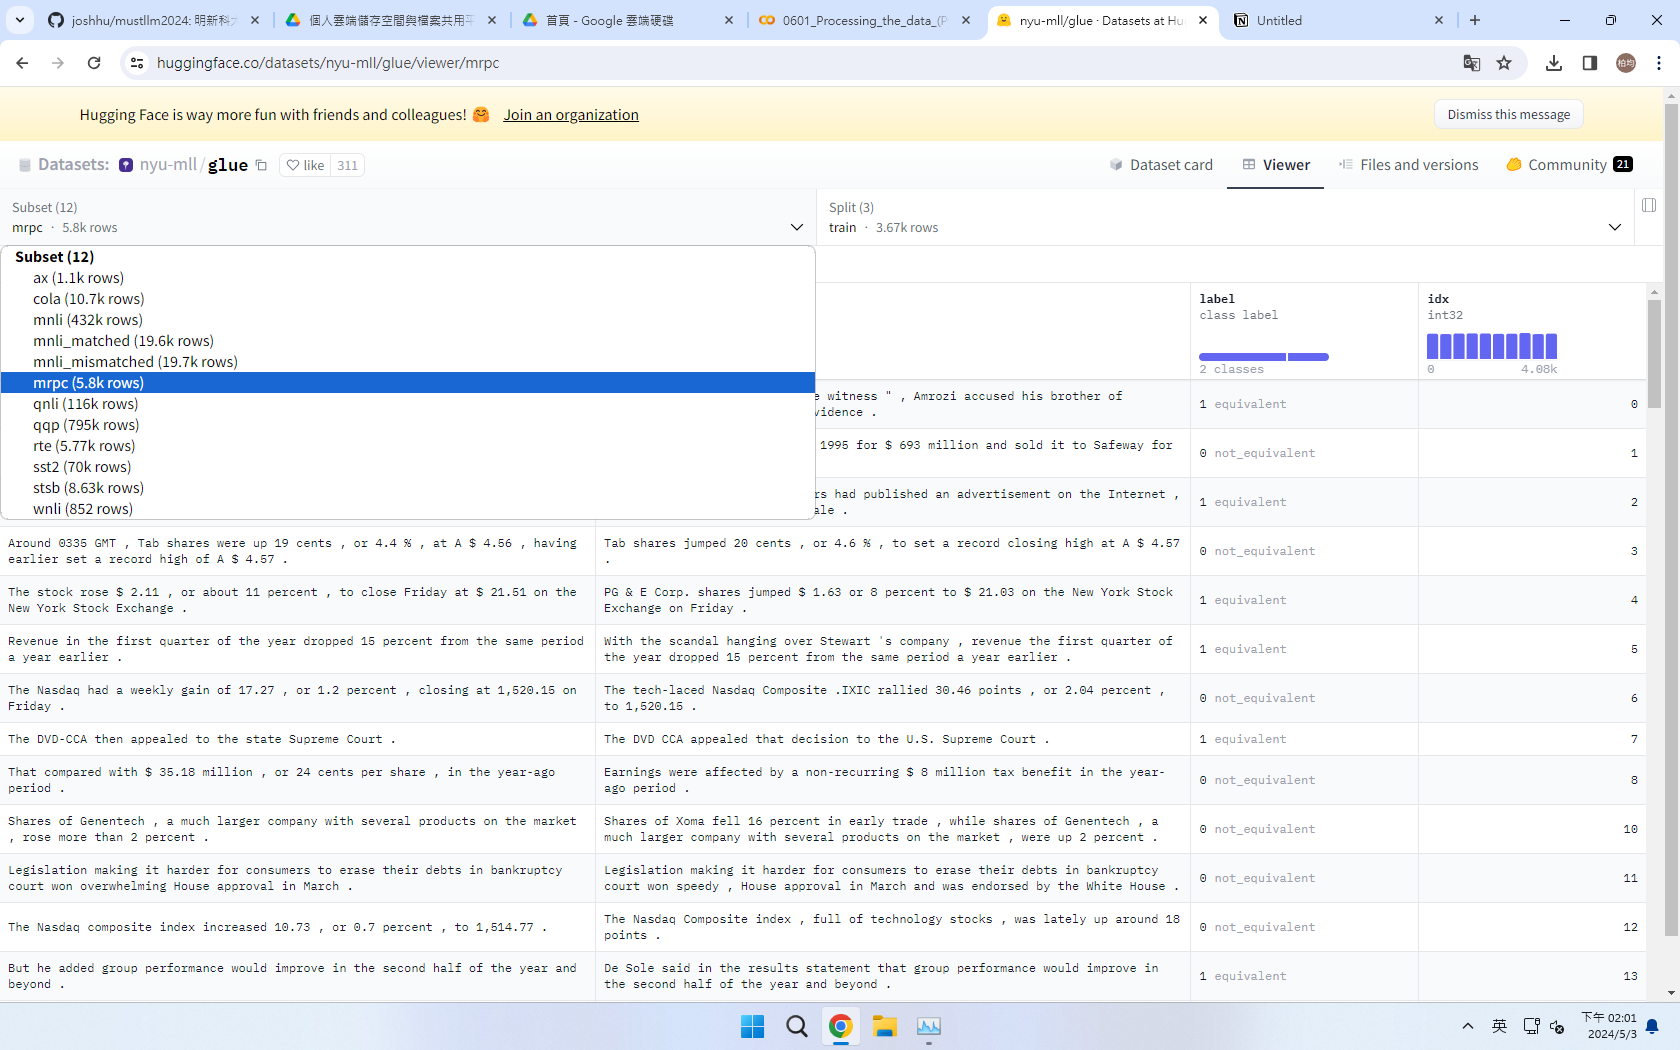

In [3]:
from datasets import load_dataset

raw_datasets = load_dataset("glue", "mrpc")  #mrpc資料集 #glue測試集 #validation訓練過程測型模型表現(月考) test:最後一次訓練(畢業考)
raw_datasets

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

得到一個`DatasetDict`包含訓練集、驗證集和測試集的物件。其中每一個都包含幾列 ( sentence1、sentence2、label和idx) 和多行，這些行是每個集合中的元素數量（訓練集中有3668對句子，驗證集中有408對句子，以及1725對句子在測試集中）。

此命令下載並快取資料集，預設位於`~/.cache/huggingface/datasets`中

透過索引來存取物件中的每對句子`raw_datasets`
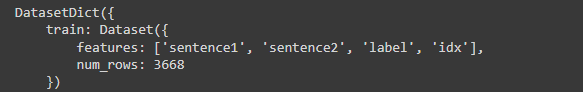

In [4]:
raw_train_dataset = raw_datasets["train"]
raw_train_dataset[0]

{'sentence1': 'Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
 'sentence2': 'Referring to him as only " the witness " , Amrozi accused his brother of deliberately distorting his evidence .',
 'label': 1,
 'idx': 0}

標籤已經是整數，因此不必進行任何預處理。要知道哪個整數對應於哪個標籤，可以用`features`檢查`raw_train_dataset`，會顯示每列的類型。`label`類型為`ClassLabel`，整數到標籤名稱的對應儲存在名稱資料夾中。0對應於`not_equivalent`, 且1對應於`equivalent`.

In [5]:
raw_train_dataset.features #有哪些keys

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

為了預處理資料集，我們需要將文字轉換為模型可以理解的數字。這是透過tokenizer完成的。可以向tokenizer提供一個句子或句子列表，因此我們可以直接對每對的所有第一個句子和所有第二個句子進行分詞，如下所示：

In [6]:
from transformers import AutoTokenizer

checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_sentences_1 = tokenizer(raw_datasets["train"]["sentence1"])
tokenized_sentences_2 = tokenizer(raw_datasets["train"]["sentence2"])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


不能只將兩個序列傳遞給模型並預測這兩個句子是否是相似。我們需要將兩個序列作為一對(pair)處理，並應用適當的預處理。tokenizer可以採用一對序列並按照 BERT 模型期望的方式進行準備

`input_ids`之外，但我們推遲討論.在這個範例中，這就是告訴模型輸入的哪個部分是第一個句子，哪個部分是第二個句子

In [16]:
inputs = tokenizer("This is the first sentence.", "This is the second one.")
inputs
#input_ids 分句

{'input_ids': [101, 2023, 2003, 1996, 2034, 6251, 1012, 102, 2023, 2003, 1996, 2117, 2028, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [8]:
tokenizer.convert_ids_to_tokens(inputs["input_ids"]) #sep當結束字元

['[CLS]',
 'this',
 'is',
 'the',
 'first',
 'sentence',
 '.',
 '[SEP]',
 'this',
 'is',
 'the',
 'second',
 'one',
 '.',
 '[SEP]']

對應輸入部分的`[CLS]`, sentence1 ID 全部為0，而對應剩餘部分的sentence2`[SEP]`類型ID全部為1

注意，不同的checkpoint，不一定包含`token_type_ids`（如果DistilBERT模型則沒有）。只有當模型知道如何處理它們時才會有，因為預訓練期間已經就已經加入了。不需要擔心`token_type_ids`標記化輸入中是否存在：只要對標記化器和模型使用相同的檢查點即可

接下來將兩個句子的資料傳給tokenizer進行處理

In [9]:
tokenized_dataset = tokenizer(
    raw_datasets["train"]["sentence1"],
    raw_datasets["train"]["sentence2"],
    padding=True,
    truncation=True,
)

使用`Dataset.map()`方法。如果需要進行更多的預處理而不僅僅是標記化，這也提供了一些額外的靈活性。此`map()`方法的工作原理是對資料集的每個元素應用一個函數，定義一個對輸入進行標記的函數

In [10]:
def tokenize_function(example): #兩句加起來回傳
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

函數接受一個字典（就像我們資料集的項目）並傳回一個帶有鍵input_ids、attention_mask和 的新字典token_type_ids。請注意，如果example字典包含多個樣本（每個鍵作為句子列表），它也適用，因為它tokenizer適用於句子對列表，如前所述。這將允許我們batched=True在呼叫中使用該選項map()，這將大大加快標記化速度。它由Tokenizers tokenizer庫中用 Rust 編寫的 tokenizer 支援。這個分詞器可以非常快，但前提是一次大量輸入

In [11]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True) #把'input_ids', 'token_type_ids', 'attention_mask' 加進tokenized
tokenized_datasets

Map:   0%|          | 0/3668 [00:00<?, ? examples/s]

Map:   0%|          | 0/408 [00:00<?, ? examples/s]

Map:   0%|          | 0/1725 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1725
    })
})

在套用預處理函數時，您甚至可以map()透過傳遞num_proc參數來使用多重處理。我們在這裡沒有這樣做，因為Tokenizers 庫已經使用多個線程來更快地標記我們的樣本，但如果您沒有使用此庫支援的快速標記生成器，這可以加快您的預處理速度。如果的預處理函數為我們應用的資料集中的現有鍵傳回新值，我們也可以變更現有欄位。

一般將資料送入模型時是一批一批的，如果一次將資料庫的所有資料都做padding或truncate會很浪費時間，每一批資料送入模型再進行處理較好。

注意，我們暫時將參數保留在標記化函數中。這是因為將所有樣本填充到最大長度效率不高：最好在建立批次時填充樣本，因為這樣我們只需要填充到該批次中的最大長度，而不是整個資料集。當輸入的長度變化很大時，這可以節省大量時間和處理能力！

### 動態填充


負責將樣本放在批次中的函數稱為collection function。您在建立時可以傳遞的參數DataLoader，預設值是一個函數，將樣本轉換為 PyTorch 張量並連接它們. 因為輸入不會全部有相同的大小。我們故意延遲填充，以便僅在每個批次上根據需要應用它，並避免出現過長的輸入和大量填充。這將大大加快訓練速度

為了在實踐中做到這一點，必須定義一個collection function，正確數量的填充應用於批次在一起的資料集的項目。Transformers庫通過`DataCollatorWithPadding`.實例化，它需要一個標記生成器（以了解要使用哪個及模型是否期望填充位於輸入的左側或右側），並將執行所有操作

In [12]:
from transformers import DataCollatorWithPadding #DataCollatorWith

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

取得訓練集中的前8筆資料，並且將不要的欄位去除(將文字去除，只留下數字欄位，也將idx去掉因為沒用)

算出批次8中每一個序列的長度，並且將這些長度放在另一個`list`中

In [13]:
samples = tokenized_datasets["train"][:8]
samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]}
#把["idx", "sentence1", "sentence2"]拿掉 留下'input_ids', 'token_type_ids', 'attention_mask'
[len(x) for x in samples["input_ids"]]

[50, 59, 47, 67, 59, 50, 62, 32]

利用定義好的data_collator將每個字pad到最大長度


In [14]:
batch = data_collator(samples) #每筆資料長度不一樣，batch長度取那批最長值即可==動態填充
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 67]),
 'token_type_ids': torch.Size([8, 67]),
 'attention_mask': torch.Size([8, 67]),
 'labels': torch.Size([8])}